## Tehtävä: Oppimisprojekti 2: Kuvantunnistus omilla kuvilla

Tämän projektin tavoitteena on suunnitella ja toteuttaa kuvantunnistusjärjestelmä käyttäen itse otettuja kuvia. Projekti toteutetaan vaiheittain hyödyntäen eri konvoluutioneuroverkkomenetelmiä yksinkertaisesta edistyneempään.

#### Datankäsittely

In [5]:
# from keras.src.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory


image_folder = '../week2_photodata/'

train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(100,100),
    shuffle=True
)



   
for images, labels in test_dataset:
    print(f"Batch of images shape: {images.shape}")

Found 180 files belonging to 4 classes.


Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Batch of images shape: (32, 100, 100, 3)
Batch of images shape: (8, 100, 100, 3)


#### Oma CNN Malli

- Rakensimme oman konvoluutio verkon
- Koulutimme mallin omalla kuvadatalla tunnistamaan hedelmiä (Omena, Päärynä, Mandariini, Banaani) 

In [6]:
from keras import Sequential, layers, regularizers
from keras.optimizers import Adam


data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.15),
  layers.RandomZoom(0.2)
])

model = Sequential([
    layers.Input(shape=(100,100, 3)),
    data_augmentation,
    layers.Rescaling(scale=1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 33856)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,166,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,186,500 (8.34 MB)

 Trainable params: 2,186,500 (8.34 MB)

 Non-trainable params: 0 (0.00 B)

##### Oman CNN Mallin callback funktiot

In [7]:
import keras

# EarlyStopping callback to stop training when validation loss stops improving
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

#### Oman CNN Mallin koulutus

In [8]:
# Model training
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2903 - loss: 4.8988 - val_accuracy: 0.7500 - val_loss: 2.0318
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6943 - loss: 1.8618 - val_accuracy: 0.9500 - val_loss: 0.9216
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7574 - loss: 1.1289 - val_accuracy: 0.9000 - val_loss: 0.7444
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8568 - loss: 0.7043 - val_accuracy: 0.9750 - val_loss: 0.4764
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8605 - loss: 0.5992 - val_accuracy: 0.9750 - val_loss: 0.3587
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9434 - loss: 0.3846 - val_accuracy: 0.8500 - val_loss: 0.5147
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8684 - loss: 0.5798 - val_accuracy: 0.9750 - val_loss: 0.2611
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9391 - loss: 0.3212 - val_accuracy: 0.9750 - v

#### Oman CNN Mallin evaluaatio

- Mallin test_loss ja test_accuracy printattuna
- Mallin loss ja accuracy graafit

Test loss: 0.06
Test accuracy: 1.00


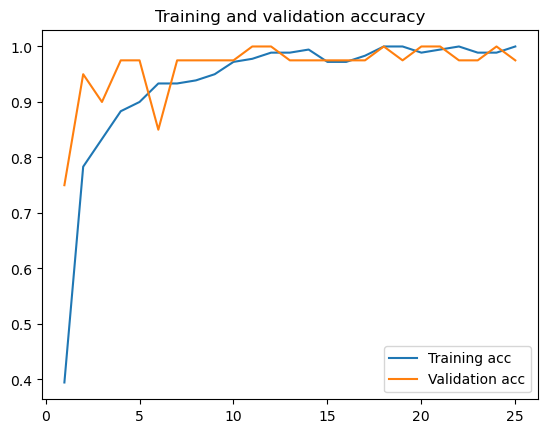

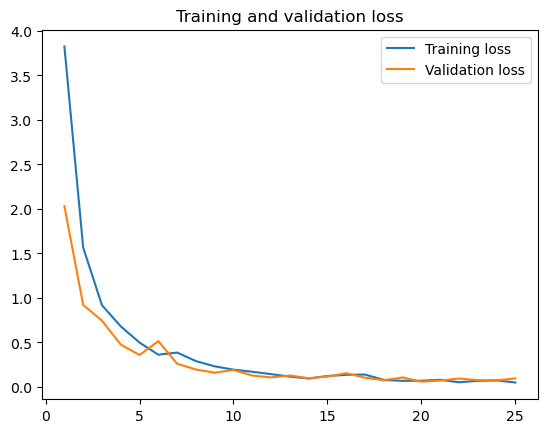

In [9]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

test_scores = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana)

- Käytimme VGG16 esikoulutettua mallia
- Skaalaamme kuvat 224 x 224 mallin vaatimaan kokoon
- Haemme pohjamallin kerasin aplikaatiosta
- Jäädytämme pohjamallin kerrokset
- Lopuksi printtaamme pohjamallin

In [10]:
# testaukseen importit uudestaan
import keras
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Get new rescaled images for VGG16 model
train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
feature_extractor.summary()

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana)

- Ominaisuuksien irroitus funktio ja ominaisuuksien irroitus
- Ominaisuudet printattuna

In [11]:
def extract_features(dataset, feature_extractor):
    features = []
    labels = []

    for images, lbls in dataset:
        preprocessed_image = keras.applications.vgg16.preprocess_input(images)
        features.append(feature_extractor.predict(preprocessed_image))
        labels.append(lbls)

    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_dataset, feature_extractor)
val_features, val_labels = extract_features(validation_dataset, feature_extractor)
test_features, test_labels = extract_features(test_dataset, feature_extractor)

print(f"Train features shape: {train_features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana)

- Ominaisuuksein muotoilu dense verkkoa varten
- Dense verkon rakennus

In [12]:
# Reshape features to fit into the Dense layer (muunnetaan vektori muotoon)
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

dense_model = Sequential([
    Dense(64, activation='relu', input_shape=(train_features.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

dense_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\M_Hin\anaconda3\envs\Tensor\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana)

- early_stop ja reduce_lr funktioiden teko
- Mallin koulutus

In [13]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)


# Train the model
history_vgg16 = dense_model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    batch_size=32,
    epochs=60,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4179 - loss: 8.4005 - val_accuracy: 1.0000 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7580 - loss: 4.0605 - val_accuracy: 0.9500 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8150 - loss: 2.9622 - val_accuracy: 1.0000 - val_loss: 9.8721e-04 - learning_rate: 0.0010
Epoch 4/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8808 - loss: 2.8710 - val_accuracy: 1.0000 - val_loss: 2.6544e-04 - learning_rate: 0.0010
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8295 - loss: 2.1431 - val_accuracy: 1.0000 - val_loss: 9.7917e-06 - learning_rate: 0.0010
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8922 - loss: 2.0394 - val_accuracy: 1.0000 - val_loss: 3.5763e-07 - learning_rate: 0.0010
Epoch 7/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9238 - loss: 0.8913 - val_accuracy: 1.

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana)

Mallin evaluaatio, printtaamme mallin tehokkuuden ja piirrämme graafit

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Feature extractor model test loss: 0.00
Feature extractor model test accuracy: 1.00


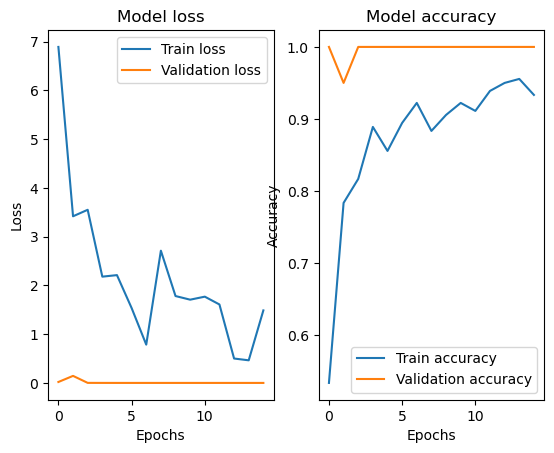

In [14]:
test_loss, test_acc = dense_model.evaluate(test_features, test_labels, verbose=1)
print(f"Feature extractor model test loss: {test_loss:.2f}")
print(f"Feature extractor model test accuracy: {test_acc:.2f}")

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Train loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Train accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### VG116 (Hienosäädetty esikoulutettu malli)

- Haemme pohjamallin kerasin kirjastosta
- Jäädytämme pohjamallin kerrokset
- Luomme oman dense verkon ja printtaammen sen lopuksi

In [15]:

from keras.src.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.src.layers import Dropout
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Get new rescaled images for VGG16 model
train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

# Define data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.15),
])


# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False)
#base_model.trainable = False

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False
    

# Add custom top layers
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x) 
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# Create the new model
model_vgg16_tuned = Model(inputs, outputs)

# Compile the model
model_vgg16_tuned.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_vgg16_tuned.summary()



Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


Found 40 files belonging to 4 classes.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential_5 (Sequential)     │ (None, 224, 224, 3)       │               0 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 224, 224)          │               0 │ sequential_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 224, 224)          │               0 │ sequential_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_2 (GetItem)          │ (None, 224, 224)          │               0 │ sequential_5[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stack (Stack)                 │ (None, 224, 224, 3)       │               0 │ get_item[0][0],            │
│                               │                           │                 │ get_item_1[0][0],          │
│                               │                           │                 │ get_item_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 224, 224, 3)       │               0 │ stack[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 7, 7, 512)         │      14,714,688 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 25088)             │               0 │ vgg16[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 32)                │         802,848 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 32)                │             128 │ dense_7[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 32)                │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 16)                │             528 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 16)                │               0 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 4)                 │              68 │ dropout_3[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 15,518,260 (59.20 MB)

 Trainable params: 803,508 (3.07 MB)

 Non-trainable params: 14,714,752 (56.13 MB)

#### VG116 (Hienosäädetty esikoulutettu malli)

Mallin ylempien kerroksien koulutus omalla datalla.

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)


# Train the model
history_vgg16 = model_vgg16_tuned.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 567ms/step - accuracy: 0.3872 - loss: 1.4548 - val_accuracy: 0.6250 - val_loss: 0.9945
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 559ms/step - accuracy: 0.6363 - loss: 0.9035 - val_accuracy: 0.8000 - val_loss: 0.3971
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 562ms/step - accuracy: 0.7540 - loss: 0.7303 - val_accuracy: 0.9500 - val_loss: 0.2534
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 565ms/step - accuracy: 0.7336 - loss: 0.6892 - val_accuracy: 0.9500 - val_loss: 0.1727
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 565ms/step - accuracy: 0.8073 - loss: 0.5592 - val_accuracy: 0.9750 - val_loss: 0.1217
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 565ms/step - accuracy: 0.8060 - loss: 0.5125 - val_accuracy: 1.0000 - val_loss: 0.1066
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - accuracy: 0.8169 - loss: 0.4989 - val_accuracy: 1.0000 - val_loss: 0.0882
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 27s 598ms/step - accuracy: 0.8667 - loss: 0.4932 - val_accu

#### VG116 (Hienosäädetty esikoulutettu malli)

Mallin evaluaatio, printataan tehokkuus luvut ja piirretään graafit lossin ja tarkkuuden osalta.

VGG16 Test loss: 0.05
VGG16 Test accuracy: 1.00


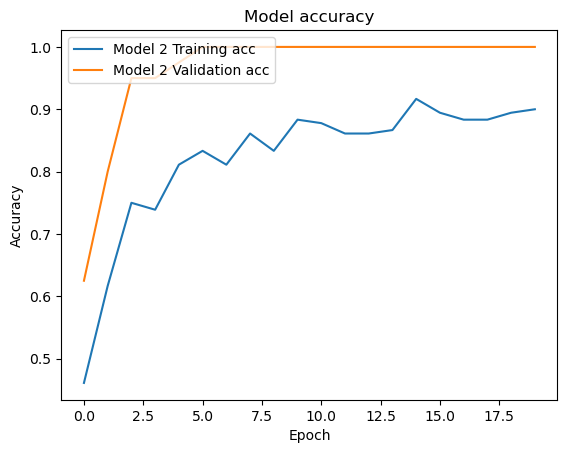

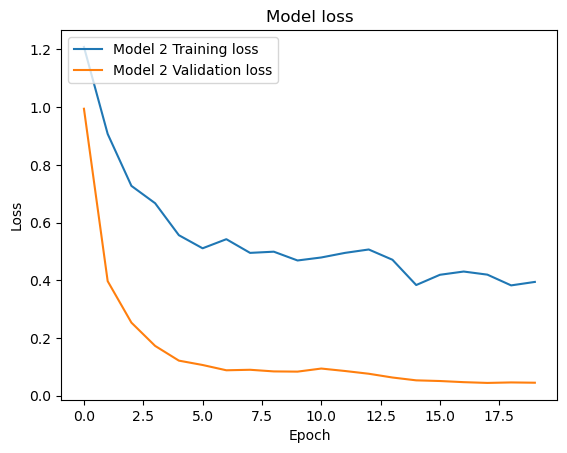

In [17]:
import matplotlib.pyplot as plt

# Evaluate the model
test_scores_vgg16 = model_vgg16_tuned.evaluate(test_dataset, verbose=0)
print(f"VGG16 Test loss: {test_scores_vgg16[0]:.2f}")
print(f"VGG16 Test accuracy: {test_scores_vgg16[1]:.2f}")

# Plot training & validation accuracy values
#plt.plot(history.history['accuracy'], label='Model 1 Training acc')
#plt.plot(history.history['val_accuracy'], label='Model 1 Validation acc')
plt.plot(history_vgg16.history['accuracy'], label='Model 2 Training acc')
plt.plot(history_vgg16.history['val_accuracy'], label='Model 2 Validation acc')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
#plt.plot(history.history['loss'], label='Model 1 Training loss')
#plt.plot(history.history['val_loss'], label='Model 1 Validation loss')
plt.plot(history_vgg16.history['loss'], label='Model 2 Training loss')
plt.plot(history_vgg16.history['val_loss'], label='Model 2 Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### VG116 (Hienosäädetty esikoulutettu malli)

Avataan jäädytetyt ylemmät kerrokset ja koulutetaan niitä omalla datalla

In [18]:
# Open freeze on base model upper layers 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False
    

# Model compile
model_vgg16_tuned.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])


In [19]:
history = model_vgg16_tuned.fit(
    train_dataset,
    epochs = 25,
    validation_data= validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 648ms/step - accuracy: 0.8753 - loss: 0.4551 - val_accuracy: 1.0000 - val_loss: 0.0553
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 642ms/step - accuracy: 0.9198 - loss: 0.3438 - val_accuracy: 1.0000 - val_loss: 0.0381
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 654ms/step - accuracy: 0.9164 - loss: 0.3651 - val_accuracy: 1.0000 - val_loss: 0.0307
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 638ms/step - accuracy: 0.9691 - loss: 0.3210 - val_accuracy: 1.0000 - val_loss: 0.0287
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - accuracy: 0.8883 - loss: 0.3619 - val_accuracy: 1.0000 - val_loss: 0.0283
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 637ms/step - accuracy: 0.9334 - loss: 0.3187 - val_accuracy: 1.0000 - val_loss: 0.0302
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 634ms/step - accuracy: 0.8971 - loss: 0.3815 - val_accuracy: 1.0000 - val_loss: 0.0243
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 642ms/step - accuracy: 0.8741 - loss: 0.5028 - val_accu

#### VG116 (Hienosäädetty esikoulutettu malli)

Mallin plottaus ja printtaus

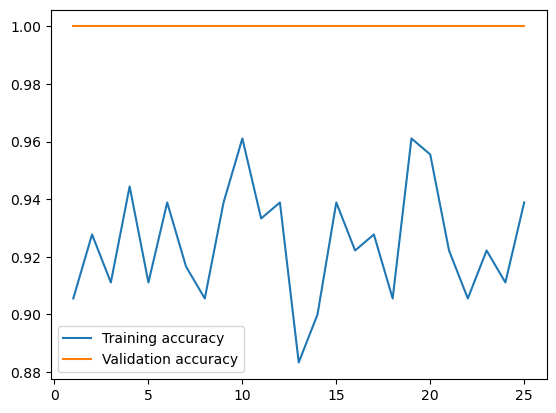

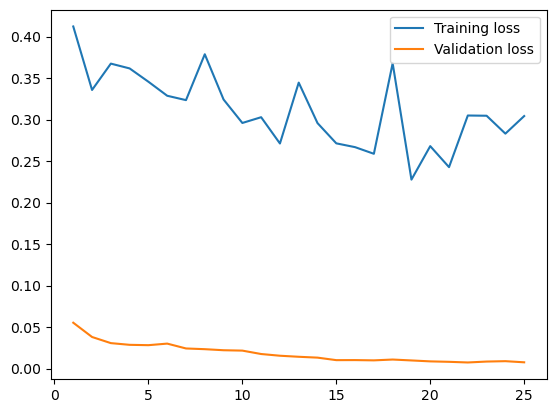

In [20]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.show()

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)


history = model_vgg16_tuned.fit(
    train_dataset,
    epochs = 20,
    validation_data= validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 639ms/step - accuracy: 0.9215 - loss: 0.3548 - val_accuracy: 1.0000 - val_loss: 0.0065
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 637ms/step - accuracy: 0.9054 - loss: 0.2636 - val_accuracy: 1.0000 - val_loss: 0.0056
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 636ms/step - accuracy: 0.9279 - loss: 0.2480 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 638ms/step - accuracy: 0.9395 - loss: 0.2380 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 638ms/step - accuracy: 0.8919 - loss: 0.3368 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 636ms/step - accuracy: 0.9235 - loss: 0.3488 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 638ms/step - accuracy: 0.9290 - loss: 0.2211 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 636ms/step - accuracy: 0.8810 - loss: 0.3607 - val_accu

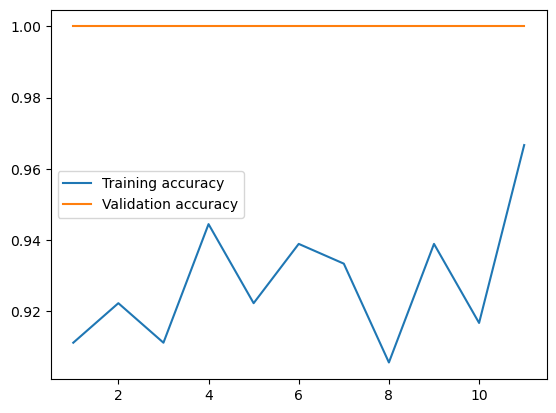

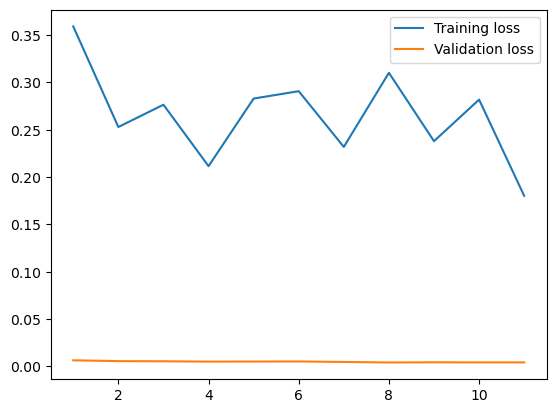

In [22]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.show()

#### Yhteenveto ja Analyysi

Tuloksia ja graafeja tarkastelemalla huomasimme, että validointidata voisi olla monipuolisempaa.